# 1. Preparation

### Import libraries

In [1]:
import os
import math
import arch
import datetime
import modelling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

C:\Users\JD\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Import data

In [2]:
x = 'XLK'
y = 'QQQ'
path = r'C:\Users\JD\Google Drive\Quantitative Trading\Data'
dfs = [pd.read_csv(os.path.join(path, ticker + '.csv'), index_col=0, parse_dates=[0], dayfirst=True) for ticker in [x, y]]
for ticker, df in zip([x, y], dfs):
    df.columns = [ticker + ' ' + col for col in df.columns]

### Pre-processing

Merge data:

In [3]:
dataset = modelling.aggregate(dfs)
datasetClean = dataset.dropna()
datasetClean.head()

,XLK Adj Close,XLK Close,XLK SplitRatio,XLK CumCashDividend,XLK CumStkDividend,QQQ Adj Close,QQQ Close,QQQ SplitRatio,QQQ CumCashDividend,QQQ CumStkDividend
GlobalQuotes Date,,,,,,,,,,
1999-03-10,28.5821,35.31,1.0,6.447,1.0,46.1041,102.13,2.0,8.096,1.0
1999-03-11,28.5336,35.25,1.0,6.447,1.0,46.3298,102.63,2.0,8.096,1.0
1999-03-12,28.2826,34.94,1.0,6.447,1.0,45.2013,100.13,2.0,8.096,1.0
1999-03-15,28.7359,35.50,1.0,6.447,1.0,46.4968,103.00,2.0,8.096,1.0
1999-03-16,29.2135,36.09,1.0,6.447,1.0,46.8941,103.88,2.0,8.096,1.0


Split data:

In [4]:
trainset, testset = modelling.splitData(datasetClean, 0.2)

### Inspecting training set

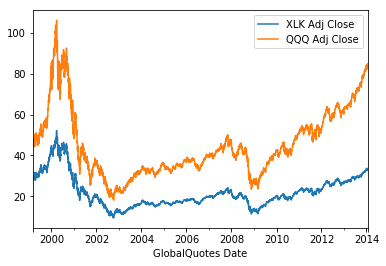

In [5]:
trainset.plot(y=[x + ' Adj Close', y + ' Adj Close'])

# 2. Modelling

### Fitting OLS model

In [6]:
olsModel = modelling.linRegWithAdf(x=trainset[x + ' Adj Close'].values, 
                                   y=trainset[y + ' Adj Close'].values, 
                                   addBias=True)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                 3.246e+04
Date:                Wed, 01 Nov 2017   Prob (F-statistic):               0.00
Time:                        01:05:09   Log-Likelihood:                -12069.
No. Observations:                3882   AIC:                         2.414e+04
Df Residuals:                    3880   BIC:                         2.416e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5109      0.263      1.944      0.0

### Plot residuals

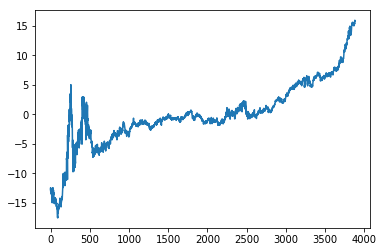

In [7]:
plt.plot(olsModel.resid)

### Testing residuals for autocorrelation

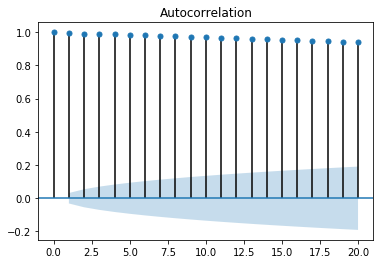

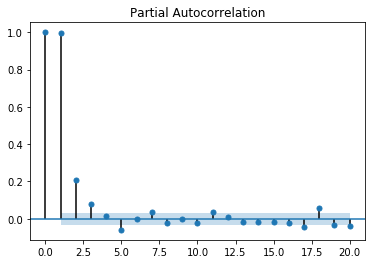

In [8]:
acfPlot = plot_acf(olsModel.resid, lags=20)
pacfPlot = plot_pacf(olsModel.resid, lags=20)

Fit ARIMA model:

In [9]:
arimaModel = ARMA(endog=olsModel.resid, order=(3, 0)).fit(trend='nc')
print(arimaModel.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3882
Model:                     ARMA(3, 0)   Log Likelihood               -1874.019
Method:                       css-mle   S.D. of innovations              0.392
Date:                Wed, 01 Nov 2017   AIC                           3756.038
Time:                        01:05:10   BIC                           3781.094
Sample:                             0   HQIC                          3764.933
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.6093      0.015     40.542      0.000       0.580       0.639
ar.L2.y        0.2006      0.018     11.153      0.000       0.165       0.236
ar.L3.y        0.1897      0.016     12.101      0.0

Check model adequacy:

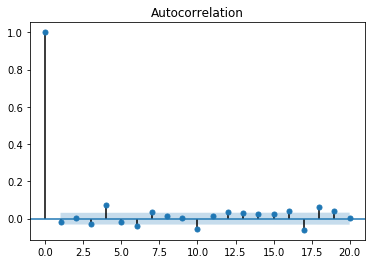

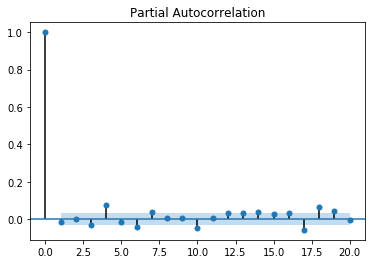

In [10]:
acfPlot = plot_acf(arimaModel.resid, lags=20)
pacfPlot = plot_pacf(arimaModel.resid, lags=20)

### Testing residuals for conditional heteroscedasticity

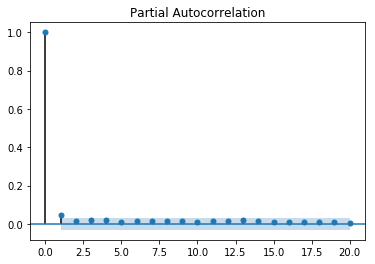

In [11]:
pacfPlot = plot_pacf(arimaModel.resid ** 2, lags=20)

# 3. Backtesting

### Backtesting on test set

CAGR: -0.0566348228528 -0.110788473106
Vol: 0.0679470734927 0.0679490598811
MaxDD: -0.238134451205 -0.364727946737
Sharpe: -0.833513791568 -1.63046366351
Calmar: -0.237827087035 -0.303756468615


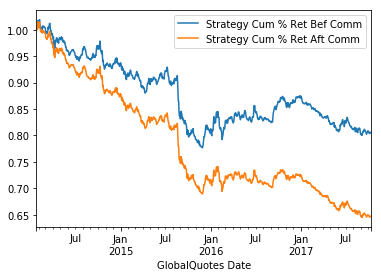

In [12]:
units = 20
testCopy = testset.copy()

# Making predictions
testCopy['Cls Spread'] = testCopy[y + ' Adj Close']  - testCopy[x + ' Adj Close'] * olsModel.params[1] - olsModel.params[0]
testCopy['Cls Spread(t-1)'] = testCopy['Cls Spread'].shift(1)
testCopy['Cls Spread(t-2)'] = testCopy['Cls Spread'].shift(2)
testCopy['Cls Spread(t+1)'] = testCopy['Cls Spread'] * arimaModel.params[0] + \
                              testCopy['Cls Spread(t-1)'] * arimaModel.params[1] + \
                              testCopy['Cls Spread(t-2)'] * arimaModel.params[2]

# Determining positions
testCopy['Positions To Take'] = [units if pred > curr else -units if pred < curr else 0 
                                 for pred, curr in zip(testCopy['Cls Spread(t+1)'].values, testCopy['Cls Spread'].values)]
testCopy['Positions Taken'] = testCopy['Positions To Take'].shift(1)
testCopy.loc[testCopy.index[0], 'Positions Taken'] = 0

# Account for commissions and etc                                                       
testCopy['Commissions'] = (testCopy['Positions Taken'].diff(1).abs() > 0) * 2
testCopy['Cls Spread'] = testCopy[y + ' Close'] - testCopy[x + ' Close']
testCopy['Cls Spread Chg'] = testCopy['Cls Spread'].diff(1)
testCopy['GAV'] = testCopy[y + ' Close']  + testCopy[x + ' Close']

# Computing returns before commissions
testCopy['Strategy $ Ret Bef Comm'] = testCopy['Cls Spread Chg'] * testCopy['Positions Taken']
testCopy['Strategy % Ret Bef Comm'] = testCopy['Strategy $ Ret Bef Comm'] / (testCopy['GAV'] * units)
testCopy['Strategy Cum % Ret Bef Comm'] = (testCopy['Strategy % Ret Bef Comm'] + 1).cumprod()

# Computing returns after commissions
testCopy['Strategy $ Ret Aft Comm'] = testCopy['Strategy $ Ret Bef Comm'] - testCopy['Commissions']
testCopy['Strategy % Ret Aft Comm'] = testCopy['Strategy $ Ret Aft Comm'] / (testCopy['GAV'] * units)
testCopy['Strategy Cum % Ret Aft Comm'] = (testCopy['Strategy % Ret Aft Comm'] + 1).cumprod()

# Computing metrics
cagrBefComm = testCopy.loc[testCopy.index[-1], 'Strategy Cum % Ret Bef Comm'] ** (365 / (testCopy.index[-1] - 
                                                                                         testCopy.index[0]).days) - 1
cagrAftComm = testCopy.loc[testCopy.index[-1], 'Strategy Cum % Ret Aft Comm'] ** (365 / (testCopy.index[-1] - 
                                                                                         testCopy.index[0]).days) - 1
volBefComm = testCopy['Strategy % Ret Bef Comm'].std() * np.sqrt(252)
volAftComm = testCopy['Strategy % Ret Aft Comm'].std() * np.sqrt(252)
maxDDBefComm = np.min(testCopy['Strategy Cum % Ret Bef Comm'] / testCopy['Strategy Cum % Ret Bef Comm'].expanding().max() - 1)
maxDDAftComm = np.min(testCopy['Strategy Cum % Ret Aft Comm'] / testCopy['Strategy Cum % Ret Aft Comm'].expanding().max() - 1)
sharpeBefComm = cagrBefComm / volBefComm
sharpeAftComm = cagrAftComm / volAftComm
calmarBefComm = cagrBefComm / abs(maxDDBefComm)
calmarAftComm = cagrAftComm / abs(maxDDAftComm)

print('CAGR:', cagrBefComm, cagrAftComm)
print('Vol:', volBefComm, volAftComm)
print('MaxDD:', maxDDBefComm, maxDDAftComm)
print('Sharpe:', sharpeBefComm, sharpeAftComm)
print('Calmar:', calmarBefComm, calmarAftComm)

testCopy.plot(y=['Strategy Cum % Ret Bef Comm', 'Strategy Cum % Ret Aft Comm'])